# 12-1. 프로젝트: End-to-End OCR

### 라이브러리 버전 확인
---
사용할 주요 라이브러리 버전을 확인해봅니다.

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


In [3]:
import os

In [102]:
from PIL import Image, ImageDraw
import numpy as np
import keras_ocr.tools
from tensorflow.keras.preprocessing.image import img_to_array
import pandas as pd
import json
import matplotlib.pyplot as plt
from PIL import ImageOps

## Recognition 모델

### 데이터 준비

우측 하단의 Cloud shell을 클릭해서 열어주세요. 아래 명령어를 통해 데이터를 준비합니다.
```
$ mkdir -p ~/aiffel/ocr 
$ ln -s ~/data ~/aiffel/ocr/data
```

In [24]:
path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [25]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


클라우드에는 이미 설치되어 있으므로 아래의 명령어는 참고로 알아두세요.
```
$ pip install lmdb
```

In [26]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현

In [28]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

### LabelConverter 클래스를 작성

In [163]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        # [[YOUR CODE]]
        for i, char in enumerate(text):
            if i>0 and char==text[i-1]:
                encoded_label.append(0) # 같은 문자 사이에 공백 문자 label 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [164]:
# LabelConverter test
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [165]:
print("Total Characters:", len(label_converter.character))
print("Character Set:", label_converter.character)

Total Characters: 37
Character Set: -ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


### loss 계산용 lambda 함수 작성

In [166]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### crnn 모델 구현

In [72]:
def build_crnn_model(input_shape=(100, 32, 3), characters=TARGET_CHARACTERS):
    """
    CRNN 모델을 구축하는 함수.

    Args:
        input_shape (tuple): 입력 이미지의 크기 (width, height, channels)
        characters (str): 인식할 문자 집합 (예: 영어, 숫자 등)

    Returns:
        keras.Model: CTC loss를 포함한 End-to-End CRNN 모델
    """
    num_chars = len(characters) + 2  # 문자 집합 크기 + 공백 문자 + CTC 필요 문자

    # 1. 입력 정의
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')  # 이미지 입력

    # 2. CNN 블록: Convolutional layers for feature extraction
    # Conv 블록 1
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)  # 다운샘플링 (W/2, H/2)

    # Conv 블록 2
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)  # 다운샘플링 (W/4, H/4)

    # Conv 블록 3
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)  # 다운샘플링 (W/4, H/8)

    # Conv 블록 4
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)  # 배치 정규화를 통해 학습 안정화
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)  # 다운샘플링 (W/4, H/16)

    # Conv 블록 5
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)  # 최종 특징 맵

    # 3. RNN 블록: Bidirectional LSTMs for sequence modeling
    # Reshape: (batch_size, width, height, channels) -> (Batch Size, Time Steps, Features)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)  # 가로 방향 시퀀스 처리 준비
    sequnce = layers.Dense(64, activation='relu')(sequnce)  # 추가 학습 가능한 레이어

    # Bidirectional LSTM 레이어
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)  # LSTM 1
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)  # LSTM 2

    # 4. 문자 분류: Fully connected layer with softmax
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)  # 문자 확률 분포 출력

    # 5. CTC Loss 계산을 위한 입력 정의
    labels = layers.Input(shape=[22], dtype='int64', name='label')  # 실제 라벨 입력
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')  # 입력 시퀀스 길이
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')  # 라벨 시퀀스 길이

    # Lambda 레이어로 CTC 손실 계산
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )

    # 6. 모델 정의
    model_input = [image_input, labels, input_length, label_length]  # 모델 입력
    model = Model(inputs=model_input, outputs=loss_out)  # CTC Loss 출력
    return model

In [73]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred}, 
    optimizer=optimizer,
    metrics=['accuracy']
)

In [74]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 50, 16, 64)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 50, 16, 128)  73856       max_pooling2d_12[0][0]           
____________________________________________________________________________________________

### 모델 학습

In [167]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

In [75]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.
ckp = ModelCheckpoint(
    filepath=checkpoint_path,  # 모델 저장 경로
    monitor='val_loss',        # 모니터링할 지표
    save_best_only=True,       # 가장 낮은 val_loss를 가진 모델만 저장
    save_weights_only=True,    # 가중치만 저장
    verbose=1                  # 저장 시 로그 출력
)

# EarlyStopping: 검증 손실(val_loss)이 개선되지 않으면 조기 종료
earlystop = EarlyStopping(
    monitor='val_loss',       # 모니터링할 지표
    patience=5,               # 개선되지 않는 에포크 수 (5 에포크 동안 개선 없으면 종료)
    restore_best_weights=True, # 가장 성능이 좋은 weight로 복원
    verbose=1                 # 조기 종료 시 로그 출력
)

- 두번의 학습에서 EarlyStopping 사용시 12~13 epoch 사이에서 멈추는 걸 확인 하였고 오버피팅 지점을 확인 하기 위해 30 에폭까지 학습

In [76]:
history_crnn_model = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=30,
    validation_data=val_set,
    validation_steps=len(val_set),
    # ModelCheckPoint와 EarlyStopping을 활용하는 경우 바로 아래 callbacks 옵션에 주석을 풀어주세요.
    callbacks=[ckp] #, earlystop] # EarlyStopping 사용 안함
)

Epoch 1/30
565/565 [==============================] - 90s 148ms/step - loss: 25.3938 - accuracy: 0.0000e+00 - val_loss: 23.0665 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 23.06653, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/30
565/565 [==============================] - 83s 146ms/step - loss: 13.8430 - accuracy: 0.0034 - val_loss: 9.6497 - val_accuracy: 0.0109

Epoch 00002: val_loss improved from 23.06653 to 9.64967, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/30
565/565 [==============================] - 82s 145ms/step - loss: 6.9072 - accuracy: 0.1022 - val_loss: 6.4774 - val_accuracy: 0.1514

Epoch 00003: val_loss improved from 9.64967 to 6.47737, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/30
565/565 [==============================] - 82s 145ms/step - loss: 5.0379 - accuracy: 0.2586 - val_loss: 5.2300 - val_accuracy: 0.2634

Epoch 00004: val_loss improved from 6.47737 to 5.22998, saving model

In [77]:
# history 저장하기
crnn_history_dir = '/aiffel/aiffel/AIFFEL_quest_rs/GoingDeeper/GD04/history'
os.makedirs(crnn_history_dir, exist_ok=True)  # 디렉토리가 없으면 생성

In [78]:
# history 파일의 전체 경로
cam_history_dir_path = os.path.join(crnn_history_dir, 'history_crnn_model.json')

In [79]:
with open(cam_history_dir_path, 'w') as f:
    pd.DataFrame(history_crnn_model.history).to_json(f)

In [80]:
# 저장된 history 가져오기
def history_conv(history):
    
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())
                     }
    
    return return_history

In [81]:
def plot_metrics(history, model_name):
    """모델의 훈련 및 검증 손실과 정확도를 하나의 행에 그리기"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 손실 그래프 (훈련 + 검증)
    axes[0].plot(history['loss'], label=f'{model_name} (Train)')
    axes[0].plot(history['val_loss'], label=f'{model_name} (Validation)')
    axes[0].set_title(f'{model_name} Loss (Train & Validation)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # 정확도 그래프 (훈련 + 검증)
    axes[1].plot(history['accuracy'], label=f'{model_name} (Train)')
    axes[1].plot(history['val_accuracy'], label=f'{model_name} (Validation)')
    axes[1].set_title(f'{model_name} Accuracy (Train & Validation)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

crnn_model


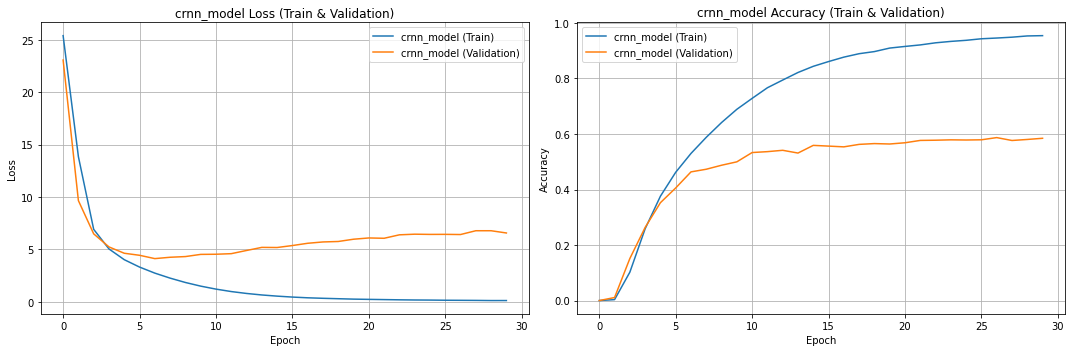

In [82]:
# 저장된 history 가져오기
with open(cam_history_dir_path, 'r') as f:
    read_history = json.load(f)
    
read_history_crnn = history_conv(read_history)

print("crnn_model")
plot_metrics(read_history_crnn, 'crnn_model')

### 테스트셋을 통해 확인

In [168]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
# 위에서 직접 훈련한 모델을 사용하기 위해 주석 처리
# checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)
print("Model weights reloaded successfully.")

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Model weights reloaded successfully.


Result: 	 SLINKING9999999999999999


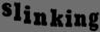

Result: 	 ALEPPO99999999999999999


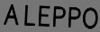

Result: 	 FWENDE999999999999999999


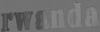

Result: 	 NATHANS99999999999999999


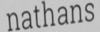

Result: 	 HALZO9999999999999999999


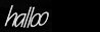

Result: 	 HURLS9999999999999999999


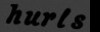

Result: 	 DOWNSIZE9999999999999999


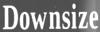

Result: 	 ROBOTIC99999999999999999


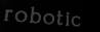

Result: 	 SLOPPY99999999999999999


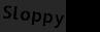

Result: 	 HERMITE99999999999999999


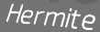

In [173]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars=TARGET_CHARACTERS):
    results = []
    # CTC 디코딩 수행
    indexes = K.get_value(
        K.ctc_decode(
            out,                             # 모델의 출력값
            input_length=np.ones(out.shape[0]) * out.shape[1],  # 입력 길이 (전체 타임스텝)
            greedy=False,                    # Beam Search 사용 여부 (False이면 Beam Search 사용)
            beam_width=5,                    # Beam Search 너비
            top_paths=1                      # 상위 1개의 결과만 반환
        )[0][0]  # 디코딩된 인덱스
    )[0]

    # 디코딩된 인덱스를 문자로 변환
    text = ""
    for index in indexes:
        text += chars[index]  # 인덱스를 TARGET_CHARACTERS에서 매핑하여 텍스트로 변환
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index=5):
    for i in range(index):  # index개의 데이터를 처리
        # 1. 데이터셋에서 입력과 출력 가져오기
        inputs, outputs = dataset[i]  # inputs: 입력 이미지, outputs: 실제 정답
        img = dataset[i][0]['input_image'][0:1, :, :, :]  # 입력 이미지를 배치 차원(1, H, W, C)으로 가져오기

        # 2. 모델 예측
        output = model.predict(img)  # CRNN 모델을 통해 예측 수행

        # 3. CTC 디코딩
        # 반환값은 리스트 형태로 구성, top_paths=1일 경우에도 반환값은 항상 리스트로 유지
        # [0]는 리스트에서 첫 번째 디코딩 결과를 가져오는 역할
        result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)[0].replace('-', '')  # 공백 문자를 제거

        # 4. 결과 출력 및 이미지 시각화
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1, 0, 2).astype(np.uint8)))  # 이미지 출력

check_inference(model_pred, test_set, index=10)

### 이미지 내 문자 위치 찾기

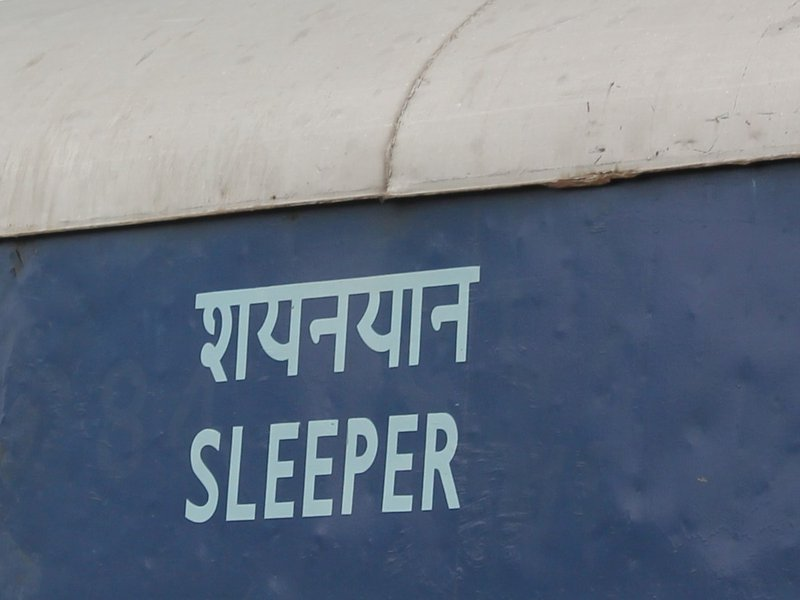 [sample.jpg]  

keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다. 이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요.

### 데이터 다운로드(☁️클라우드 유저용)
---
step3에서 심볼릭 링크를 사용한 경우, sample.jpg는 ~/aiffel/ocr/data디렉토리에 있습니다.

In [154]:
from keras_ocr.detection import Detector
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 단어의 영역을 잘라오도록 해주세요.

In [155]:
def detect_text(img_path):
    # 이미지 읽기 및 변환
    img_pil = Image.open(img_path).convert('RGB')  # PIL 이미지로 로드
    img_draw = ImageDraw.Draw(img_pil)  # 시각화를 위해 draw 객체 생성

    # Keras-OCR 형식에 맞는 배열로 변환 (H, W, C)
    img_array = keras_ocr.tools.read(img_path)  # numpy 배열 (H, W, C)로 변환
    img_batch = np.expand_dims(img_array, axis=0)  # 배치 차원 추가 (1, H, W, C)

    # Detector로 텍스트 영역 감지
    ocr_result = detector.detect(img_batch)[0]  # 배치의 첫 번째 결과만 가져오기

    # 시각화를 위한 다각형 그리기 및 텍스트 영역 크롭
    cropped_imgs = []
    for text_result in ocr_result:
        # 감지된 영역을 빨간색 다각형으로 표시
        img_draw.polygon(text_result, outline='red')

        # 텍스트 영역 좌표 계산
        x_min = text_result[:, 0].min() - 5  # x 좌표 최소값
        x_max = text_result[:, 0].max() + 5  # x 좌표 최대값
        y_min = text_result[:, 1].min() - 5  # y 좌표 최소값
        y_max = text_result[:, 1].max() + 5  # y 좌표 최대값

        # 텍스트 영역 크롭
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))  # 잘라낸 이미지를 리스트에 추가

    # 탐지된 이미지 반환
    result_img = img_pil  # 탐지된 결과 이미지
    return result_img, cropped_imgs

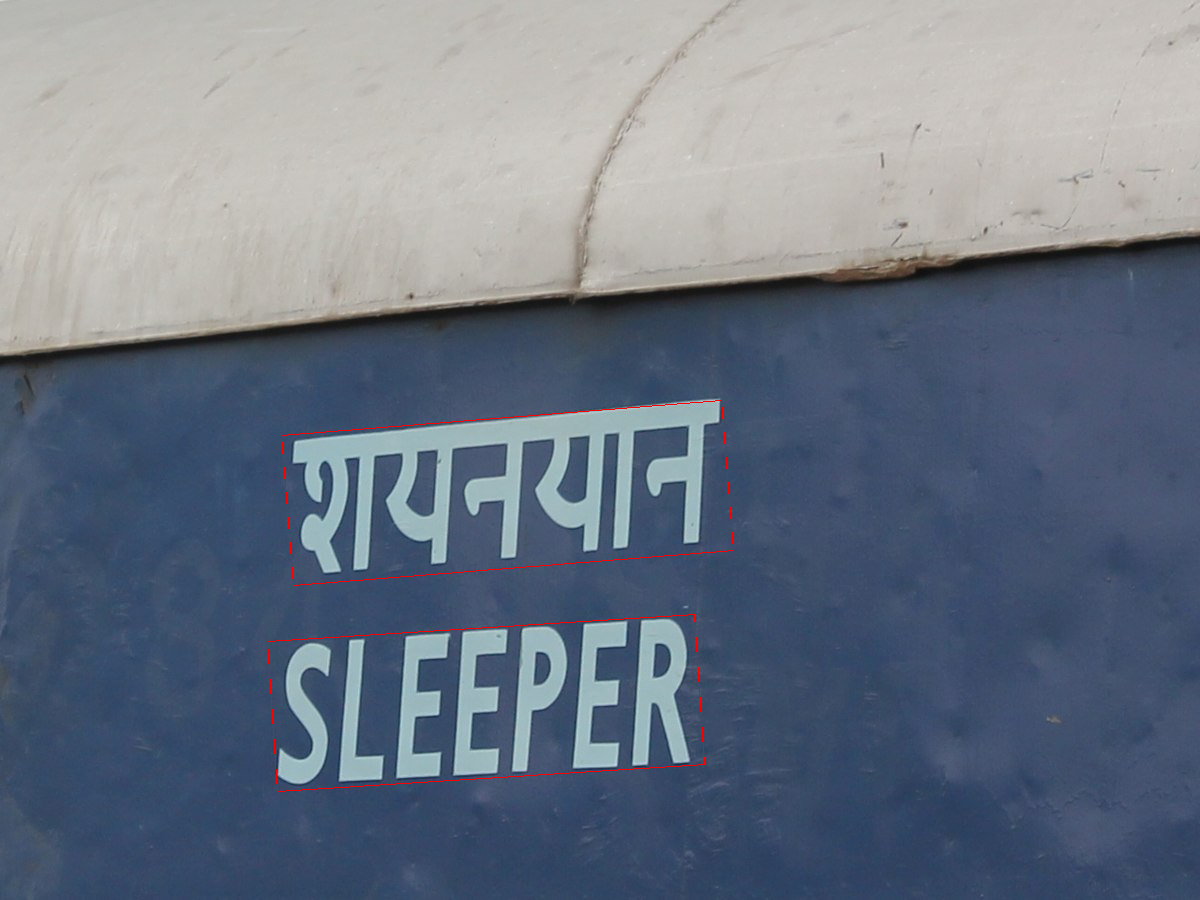

In [156]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

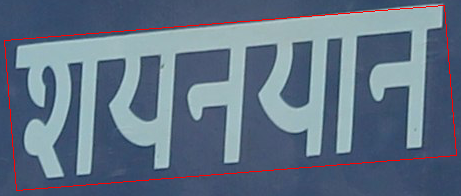

Cropped Image 1 Size: (461, 196)


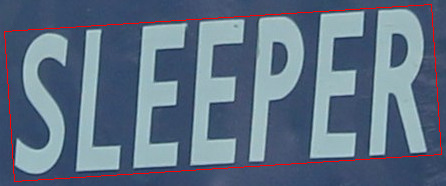

Cropped Image 2 Size: (446, 186)


In [157]:
# 크롭된 텍스트 이미지 확인
for i, img in enumerate(cropped_img):
    # cropped_img.show(title=f"Cropped Image {i+1}")
    display(img)
    print(f"Cropped Image {i+1} Size: {img.size}")  # 이미지 크기 출력

이제 위에서 이미지 내의 단어 이미지를 얻었습니다. 그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보세요!

### 코드 설명

```python
pil_img.resize((100, 32), 3)
```
    - 입력 이미지(pil_img)를 (100, 32) 크기로 조정
    - 3은 리사이즈 방식(Image.BICUBIC)을 나타내며, 고품질의 리사이징을 수행  


```python
np.array(pil_img.resize((100, 32), 3)).transpose(1, 0, 2)
```
    - PIL 이미지를 NumPy 배열로 변환
    - .transpose(1, 0, 2)는 축을 전환하여 (height, width, channels) 에서 (width, height, channels)로 변경
        - 일반적으로 이미지 데이터는 (height, width, channels) 의 형식으로 표현됩니다. 예를 들어, PIL로 이미지를 로드한 경우:
            ```
            (height, width, channels)  # 예: (32, 100, 3)
            ```
        - CRNN 모델은 (width, height, channels) 형식의 데이터를 입력으로 받음  
    
        
```python
np.expand_dims(..., axis=0)
```
    - 변환된 이미지를 np.expand_dims를 사용하여 배치 차원을 추가
        - 최종 형태: (1, 32, 100, 3)
    
```python
output = model_pred.predict(...)
```
    - output은 시퀀스 형태로 각 타임스텝별 문자 확률 분포를 포함

```python
result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-', '')
```
    - decode_predict_ctc 함수를 사용해 CTC 디코딩을 수행하여 예측된 시퀀스를 텍스트로 변환
    - 공백 문자('-')는 .replace('-', '')를 통해 제거

```python
display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))
```
    - 이미지를 다시 NumPy 배열에서 PIL 이미지로 변환하고, 이를 시각적으로 출력

In [170]:
def recognize_img(pil_img, input_img_size=(100,32)):
    output = model_pred.predict(np.expand_dims(np.array(pil_img.resize((100, 32), 3)).transpose(1, 0, 2), axis=0))
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))

Result: 	 XTUEUIE99999999999999999


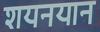

Result: 	 SLEEPER9999999999999999


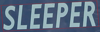

In [171]:
for _img in cropped_img:
    recognize_img(_img)

### 영어는 정확하게 SLEEPER 로 검출이 되었지만 영어가 아닌 단어는 엉뚱한 스펠링으로 추론 함

### 추가 실험
- 다른 이미지를 추가 하여 성능을 더 검증 해 보려고 한다.

In [180]:
SAMPLE_IMG_PATH1 = os.getenv('HOME') +'/aiffel/AIFFEL_quest_rs/GoingDeeper/GD04/sample1.jpg'
SAMPLE_IMG_PATH2 = os.getenv('HOME') + '/aiffel/AIFFEL_quest_rs/GoingDeeper/GD04/sample2.jpg'
SAMPLE_IMG_PATH3 = os.getenv('HOME') + '/aiffel/AIFFEL_quest_rs/GoingDeeper/GD04/sample3.jpg'

In [176]:
def process_sample_image(image_path):
    """
    주어진 이미지 경로에서 텍스트를 감지하고 크롭된 텍스트 이미지를
    인식하여 결과를 출력하는 함수.

    Args:
        image_path (str): 처리할 이미지 파일 경로

    Returns:
        None
    """
    # 1. 이미지에서 텍스트 감지
    img_pil, cropped_imgs = detect_text(image_path)

    # 2. 감지된 텍스트 영역 표시
    print("Detected Text Regions:")
    display(img_pil)

    # 3. 크롭된 텍스트 이미지 확인 및 크기 출력
    for i, img in enumerate(cropped_imgs):
        display(img)
        print(f"Cropped Image {i+1} Size: {img.size}")

    # 4. 크롭된 이미지에서 텍스트 인식
    print("Recognized Texts:")
    for i, _img in enumerate(cropped_imgs):
        try:
            recognized_text = recognize_img(_img)
            print(f"Recognized Text {i+1}: {recognized_text}")
        except Exception as e:
            print(f"Error processing Cropped Image {i+1}: {e}")


Detected Text Regions:


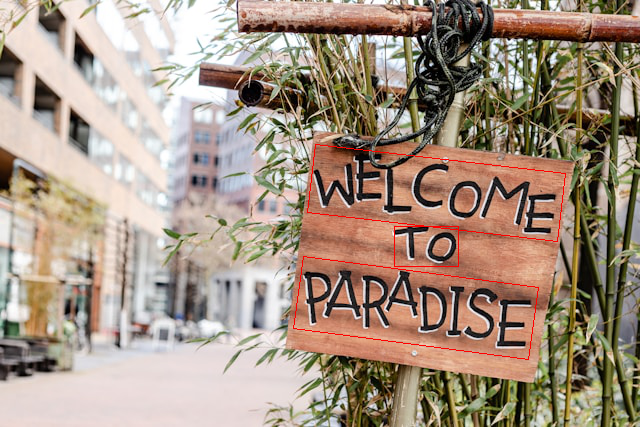

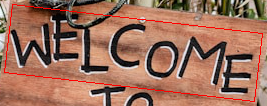

Cropped Image 1 Size: (267, 106)


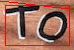

Cropped Image 2 Size: (74, 50)


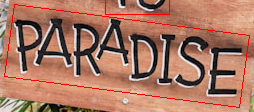

Cropped Image 3 Size: (254, 112)
Recognized Texts:
Result: 	 METGOME99999999999999999


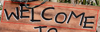

Recognized Text 1: None
Result: 	 UZDR99999999999999999999


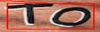

Recognized Text 2: None
Result: 	 RARADISE9999999999999999


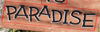

Recognized Text 3: None


In [177]:
process_sample_image(SAMPLE_IMG_PATH1)

Detected Text Regions:


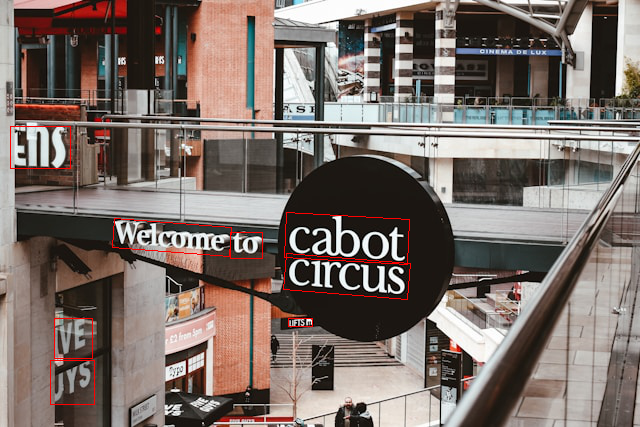

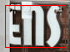

Cropped Image 1 Size: (70, 52)


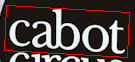

Cropped Image 2 Size: (135, 62)


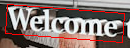

Cropped Image 3 Size: (130, 48)


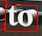

Cropped Image 4 Size: (42, 36)


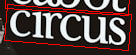

Cropped Image 5 Size: (136, 55)


Cropped Image 6 Size: (34, 18)


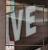

Cropped Image 7 Size: (48, 50)


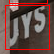

Cropped Image 8 Size: (54, 54)
Recognized Texts:
Result: 	 IELESE999999999999999999


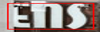

Recognized Text 1: None
Result: 	 LCALBOT99999999999999999


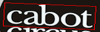

Recognized Text 2: None
Result: 	 WECOTER9999999999999999


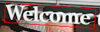

Recognized Text 3: None
Result: 	 RZORT9999999999999999999


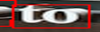

Recognized Text 4: None
Result: 	 RCIRCUS99999999999999999


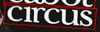

Recognized Text 5: None
Result: 	 NTISRM999999999999999999


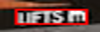

Recognized Text 6: None
Result: 	 ERES99999999999999999999


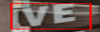

Recognized Text 7: None
Result: 	 TS9999999999999999999999


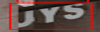

Recognized Text 8: None


In [181]:
process_sample_image(SAMPLE_IMG_PATH2)

Detected Text Regions:


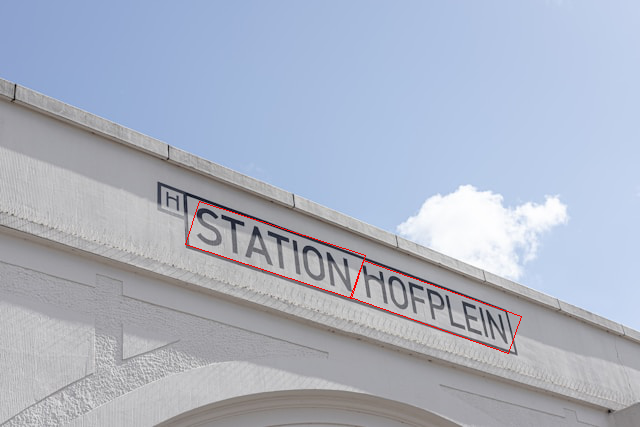

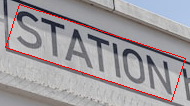

Cropped Image 1 Size: (190, 106)


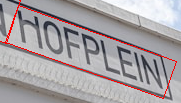

Cropped Image 2 Size: (181, 103)
Recognized Texts:
Result: 	 ISTETIORS99999999999999


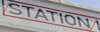

Recognized Text 1: None
Result: 	 CORENY99999999999999999


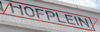

Recognized Text 2: None


In [182]:
process_sample_image(SAMPLE_IMG_PATH3)

### 회고
- 이미지 처리 후 문자열 처리에서 sequnce 변경시 이해 하기 어려운 부분이 있었다.
- MJDatasetSequence 부분과 decode_predict_ctc 코드 부분은 이해가 더 필요 할 거 같다.
- ALEPPO99999999999999999 로 99999... 가 붙는데 왜 나오는지 확인 해 봐야 할 거 같다.
- detect 영역은 정확하게 추론 하였지만 그에 반해 Recognition 성능은 떨어졌다.

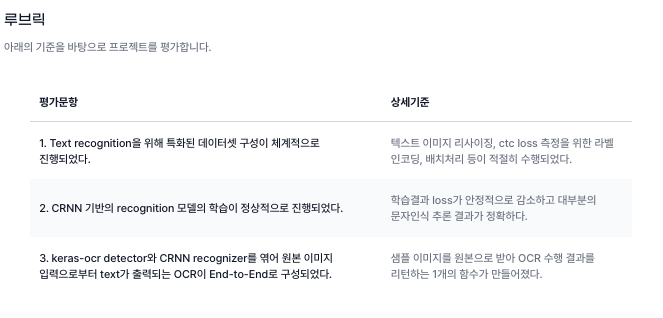